## Analysing sparse wavelet attack on an image

### Introduction and supporting libraries

We wish to analyse adversarial perturbations where we restrict the structure of the adversarial mask that we apply to be on the support of the image. We do this by performing a gradient attack on the classifier in the wavelet domain of the image. As a result we need to be able to compute the wavelet transform of an image, while also being able to calculate the the derivative of the loss function of the classifier with the wavelet weights in question. We will use Pytorch as the platform for the classification, hence we are required to implement a wavelet transform in Pytorch. To do this we will leverage the nice work from Thomas Viehmann in his jupyter notebook "2D Wavelet Transformation in PyTorch" (Link: https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/2D-Wavelet-Transform.ipynb).

Firstly lets import the libraries that we will need now and also later on:

In [1]:
# We will leverage the pywavelets library to build our own wavelet transform
import pywt

# These imports we will need when it comes to plotting our results

import matplotlib
import matplotlib.pyplot as plt

# Numpy and copy are useful libraries we will use, while PIL will support out image manipulation
import numpy as np
from PIL import Image
import copy

# The below libraries are required so that we can leverage pytorch in the way we want
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch import nn
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader

### Image processing functions

As we are concerned with images and image classification we will next proceed to execute some image processing functiosn that we will need. For Pytorch classifiers images are expected to have had a z transform applied to them in order - this is done to improve training and convergence and avoid the magnitude or units of a feature impacting the importance of the feature.

In [2]:
# Channel means refer to the mean pixel values for each of the three channels RGB
channel_means = [0.485, 0.456, 0.406]

# Channel std refer to the standard deviation of the pixel values for each of the three channels RGB
channel_stds = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(
    mean=channel_means,
    std=channel_stds
)

# Preprocess applies scaling of the image, cropping of image dimenensions, conversion to a tensor and then normalisation
preprocess = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# No preprocess simply crops it and then transfroms to a tensor, note that ToTensor performs scaling to [0, 1]
# so we need to undo this
no_preprocess = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])

def load_image(img_path):
    img_pil = Image.open(img_path).convert('RGB')
    img_tensor = no_preprocess(img_pil)*256 
    img_tensor = img_tensor.unsqueeze_(0) # Turn tensor into a batch format with 1 image
    img_tensor_norm = preprocess(img_pil)
    img_tensor_norm = img_tensor_norm.unsqueeze_(0) # Turn tensor into a batch format with 1 image
    return img_pil, img_tensor.double(), img_tensor_norm.double()


def get_image_from_tensor(img_tensor):
    temp = img_tensor.numpy()
    temp = np.squeeze(temp, axis=0) 
    temp = np.swapaxes(temp, 0, 1)
    temp = np.swapaxes(temp, 1, 2)
    temp = temp.clip(0, 255)
    temp = temp.astype('uint8')
    img_pil = Image.fromarray(temp)
    return img_pil

def unprocess_norm_tensor(img_tensor):
    temp = copy.copy(img_tensor)
    for i in range(3):
        temp[0][i] = temp[0][i]*channel_stds[i] + channel_means[i]
    temp = temp*256
    return temp

### Implementing the wavelet transform in Pytorch

Now let us define our wavelet filters that we will leverage to build our wavelet and inverse wavelet transforms:

In [3]:
# Define the wavelet filter we wish to create
w=pywt.Wavelet('bior2.2')

# Take coefficient values from pywavelet implmenetation of 2D wavelet transform
dec_hi = torch.Tensor(w.dec_hi[::-1]) 
dec_lo = torch.Tensor(w.dec_lo[::-1])
rec_hi = torch.Tensor(w.rec_hi)
rec_lo = torch.Tensor(w.rec_lo)

# Stack filters so that wavelet transform can be implemented as a convolution
filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0).double()

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0).double()

# Functions for processing wavelet and inverse wavelet transform
def wt(vimg, levels=1):
    # Input: takes tensor of pixel values of a single layer of an image, e.g. blue, with dimensions [height][width]
    # Output: returns tensor of wavelet coefficients with dimensions [height][width]
    h = vimg.size(2)
    w = vimg.size(3)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res


def iwt(vres, levels=1):
    # Input: takes tensor of wavelet coefficients values for a single image layer with dimensions [height][width]
    # Output: returns tensor of pixel values for a single image layer with dimensions [height][width]
    h = vres.size(2)
    w = vres.size(3)
    res = vres.view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2]
    return res

def calc_wav_coeffs_tensor_from_image_tensor(vimg, levels=1):
    # Calculates wavelet transform of an image     
    # Input: takes tensor of pixel values with dimensions as [batch][channel][height][width]
    # Output: returns tensor of wavelet coefficients with dimensions as [batch][channel][height][width]
    c = vimg.size(1)
    coeffs_list = []
    for i in range(c):
        layer = vimg[0][i]
        layer = layer[None][None]
        layer_coeffs = wt(layer, levels)
        coeffs_list.append(layer_coeffs)
    coeffs = torch.cat(coeffs_list, dim=1)
    coeffs = coeffs.double()
    return coeffs.data


def calc_image_var_from_coeffs_var(coeffs_var, levels=1):
    # Calculates inverse wavelet transform of an image 
    # Input: takes pytorch variable containing tensor of wavelet coefficients with dimensions as
    # [batch][channel][height][width]
    # Output: returns tensor of pixel values with dimensions as [batch][channel][height][width]
    c = coeffs_var.size(1)
    image_list = []
    for i in range(c):
        layer = coeffs_var[0][i]
        layer = layer[None][None]
        layer_image = iwt(layer, levels)
        image_list.append(layer_image)
    image = torch.cat(image_list, dim=1)
    image = image.double()
    return image

### Testing the wavelet transform

Let us now test our newly defined wavelet transform on an image to check that it works properly. We will import an image, calculate the wavelet transform to a certain level and then display the result.

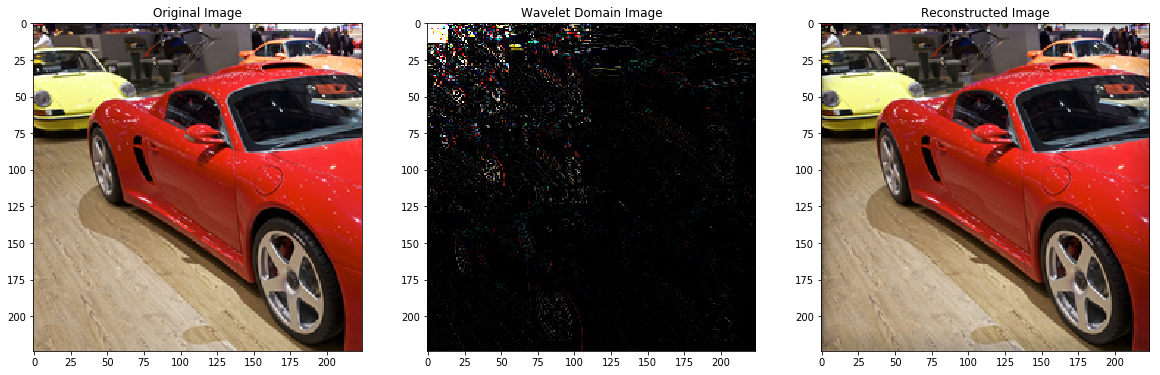

In [4]:
# Number of levels of wavelet transform
levels = 4

# Define the path of the image to test the wavelet transform on, can swap other images to test on:
# img_path = "test-images/butterfly.png"
img_path = "test-images/car.png"
# img_path = "test-images/panda.png"
# img_path = "test-images/snail.png"
# img_path = "test-images/food.png"
# img_path = "test-images/shoes.png"

# Load the image as a pil, a pytorch tensor and another normalised pytorch tensor (see functions above)
img_pil_uncropped, img_tensor, img_tensor_norm = load_image(img_path)

# We will calculate the wavlet transform of non-normalised version of the image (norm version is used by classifier)
wav_coeffs_tensor = calc_wav_coeffs_tensor_from_image_tensor(img_tensor, levels)
wav_coeffs_var = Variable(wav_coeffs_tensor, requires_grad = False)

# Create a PIL of the wavelet transform to view it - note have to remove pre-processing for display
wav_coeffs_pil = get_image_from_tensor(wav_coeffs_tensor)

# Calculate the reconstruction of the image from the wavelet coefficients
img_recon_var = calc_image_var_from_coeffs_var(wav_coeffs_var, levels)
img_recon_tensor = img_recon_var.data

# Get a PIL image from the reconstructed image tensor
img_recon_pil = get_image_from_tensor(img_recon_tensor)

# Get a PIL image for the image tensor that is cropped
img_pil = get_image_from_tensor(img_tensor)

plt.figure(1, figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Original Image');
plt.imshow(img_pil)
plt.subplot(1,3,2)
plt.title('Wavelet Domain Image');
plt.imshow(wav_coeffs_pil)
plt.subplot(1,3,3)
plt.title('Reconstructed Image')
plt.imshow(img_recon_pil)
plt.show()




It seems that our code works fairly well! Note that reconstruction is slightly blurred, this is due to the fact that we aren't handling the wavelet transform at the edges properly. In fact let us diplay the errors in the reconstruction: [NEED TO LOOK INTO THIS]

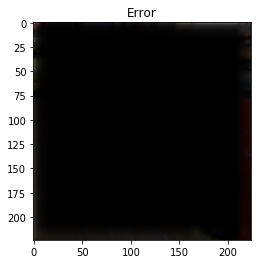

In [5]:
error = torch.abs(img_tensor - img_recon_tensor)
error_pil = get_image_from_tensor(error)

plt.figure(2)
plt.title('Error');
plt.imshow(error_pil)

### Image classification with Squeezenet

We require a classifier to test our adversary and theories concerning perturbations restructed to the waveket support. For this we shall use Squeezenet, a competitive yet memory efficient (relatively sparsely connected) neural network classifier. More information on squeezenet can be found through the following links:
1. Pytorch documentation - http://pytorch.org/docs/master/torchvision/models.html
2. Squeezenet paper - https://arxiv.org/abs/1602.07360

Let us now import squeezenet, classification labels and define a function that we can call to run classification queries:

In [6]:
# IMPORT NETWORK:

# Import a pre-trained squeezenet
model = models.squeezenet1_1(pretrained=True).double()

# Define the loss function as the cross entropy
loss = nn.CrossEntropyLoss()

# Sets the module into evaluation mode - set self.train(False)
model.eval();

# Import classification labels
labels = eval(open('classes.txt').read())

# Classify an image using the defined classifier network / model
def classify_image(img_tensor, classifier, labels):
    # Classifies an image based on its normalised pytorch tensor
    # Inputs: a tensor containing the pre-processed pixel values
    # Output: a classification label and a confidence   
    output = classifier(Variable(img_tensor, requires_grad=True))
    confidence = output.data.numpy().max()
    classification = labels[output.data.numpy().argmax()]
    return confidence, classification

We will now load in and test the classification performance of an imported pretrained squeezenet from Pytorch on an image and the reconstruction of the image:

In [7]:
# Number of levels of wavelet transform
levels = 4

# Define the path of the image to test the wavelet transform on, can swap other images to test on:
img_path = "test-images/butterfly.png"
# img_path = "test-images/car.png"
# img_path = "test-images/panda.png"
# img_path = "test-images/snail.png"
# img_path = "test-images/food.png"
# img_path = "test-images/shoes.png"

# Load the image as a pil, a pytorch tensor and another normalised pytorch tensor (see functions above)
img_pil_uncropped, img_tensor, img_tensor_norm = load_image(img_path)

# We will calculate the wavlet transform of non-normalised version of the image (norm version is used by classifier)
wav_coeffs_tensor = calc_wav_coeffs_tensor_from_image_tensor(img_tensor, levels)
wav_coeffs_var = Variable(wav_coeffs_tensor, requires_grad = False)

# Calculate the reconstruction of the image from the wavelet coefficients
img_recon_var = calc_image_var_from_coeffs_var(wav_coeffs_var, levels)
img_recon_tensor = img_recon_var.data

orig_conf, orig_class = classify_image(img_tensor, model, labels)
recon_conf, recon_class = classify_image(img_recon_tensor, model, labels)

print("Class: " + str(orig_class) + " Confidence : " + str(orig_conf))
print("Class: " + str(recon_class) + " Confidence : " + str(recon_conf))

Class: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus Confidence : 420.446407073
Class: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus Confidence : 419.056737569


Clearly the above results show that the classifier is able to accuratly classify the images given to it (which we would expect given that these are ImageNet images and the pretrained Squeezenet model was trained on ImageNet!), and also that as expected the wavelet reconstruction is classified with almost exactly the same confidece as the original. We may now proceed to our primary goal - generating adversaries on the same wavelet support as the target image in question. [INTERESTING TO NOTE - TEST NORMED TENSOR VS UNNORMED}

### Experiment goals and setup
In this experiment we are aiming to demonstrate the effectiveness of an adversarial attack, generated by altering the coefficients of the $k$ largest biorthongal 2.2 wavelet components of the image. To this end we execute the following steps:
1. Load in target image and classify it using a pretrained squeezenet instance. The squeezenet should classify the image correctly
2. Calculate the wavelet transform of the image and find the $k$ largest wavelet components and their coefficiencts $\{w_k\}$
3. Using backpropogation iteratively update $\{w_k\}$ using gradient descent so that the resulting perturbed image is moved towards a classification boundary

To do this we need to define two new functions, one that identifies the locations of the $k$ largest coefficients and the second, provided with an image and a classifier creates an adversary. These are shown below:

In [21]:
def get_K_target_coeff_indices(img_coeffs, K):
    # Inputs: the wavelet coefficient array of an image and K - the number of coefficients of interest
    # Output: locations of the K largest coefficients in the wavelet coefficient array as a torch tensor
    img_coeffs_array = img_coeffs.numpy()
    coeff_size_order = np.dstack(np.unravel_index(np.argsort(abs(img_coeffs_array).ravel()), (img_coeffs_array.shape[0], img_coeffs_array.shape[1], img_coeffs_array.shape[2], img_coeffs_array.shape[3])))
    target_coeffs = coeff_size_order[0][-K:len(coeff_size_order[0])]
    # target_coeffs = torch.from_numpy(target_coeffs)
    return target_coeffs


def create_adversary_nontargeted(original_img_tensor, levels, K, labels, step_alpha):
    # Calculate wavelet transform of image
    original_coeffs_tensor = calc_wav_coeffs_tensor_from_image_tensor(original_img_tensor, levels)

    # Find locations of K largest coefficients (target coefficients)
    tc = get_K_target_coeff_indices(original_coeffs_tensor, K)

    # Copy / clone the coefficients of the image to a new Variable
    y = Variable(torch.zeros(1, 1))
    perturbed_coeffs_var = Variable(original_coeffs_tensor.clone(), requires_grad = True)
    
    # Execute gradient descent attack on wavelet target wavelet coefficients:
    for step in range(steps):
        # Ensure that gradients are intialised to zero
        zero_gradients(perturbed_coeffs_var)
        # Update the pertrubed image variable with coefficients calculated in the last iteration
        # (note needs to be variable do we can calc the gradient)
        perturbed_img_var = calc_image_var_from_coeffs_var(perturbed_coeffs_var, levels)        
        # Classify the perturbed image
        out = model(perturbed_img_var)
        # Set the data in variable y to be equal to a tensor containing the max confidence
        y.data = out.data.max(1)[1]
        # Store in classification guess and classification confidence as variables          
        classification = labels[out.data.numpy().argmax()]
        classification_confidence = out.max()
        
        # If is the first step then perturbed image is the original, store this classification
        if step == 0:
            original_classification = copy.copy(classification)
            original_confidence = out.max()
            print("\nClassification of original image: " + str(original_classification) + ' with confidence ' + str(original_confidence.data))
        
        # Check if the classification of the perturbed image is different to the original, if it is then exit as
        # have been successful!
        if classification != original_classification:
            print("\nAttack successful at step " + str(step) + ": miss-classification detected - peturbed image now classified as: " + str(classification) + ' with confidence ' + str(classification_confidence.data))
            exit_status = 1
            break
            
        # If has not been successful then calculate the loss (cross entropy) between the entire output and the max output
        _loss = loss(out, y)

        # Compute gradient of all variables in the model graph
        _loss.backward()

        # Update the wavelet coefficients using gradient descent
        for i in range(len(tc)):
            perturbed_coeffs_var.data[tc[i][0]][tc[i][1]][tc[i][2]][tc[i][3]] = perturbed_coeffs_var.data[tc[i][0]][tc[i][1]][tc[i][2]][tc[i][3]] + step_alpha*(np.sign(perturbed_coeffs_var.grad.data[tc[i][0]][tc[i][1]][tc[i][2]][tc[i][3]]))

    if (step+1) == steps:
        print("\nAttack unsuccessful after " + str(steps) + " steps, consider increasing number of steps or increasing step size")
        exit_status = 0

    # Create image from perturbed coefficients:
    perturbed_img_var = calc_image_var_from_coeffs_var(perturbed_coeffs_var, levels)
    perturbed_img_tensor = perturbed_img_var.data 
    mask_img_tensor = perturbed_img_tensor - original_img_tensor

    for i in range(3):
        mask_img_tensor[0][i] = mask_img_tensor[0][i] - channel_means[i]/channel_stds[i]

    # Remove image normalisation from tensor
    perturbed_img_tensor = unprocess_norm_tensor(perturbed_img_tensor)
    mask_img_tensor = unprocess_norm_tensor(mask_img_tensor)
    
    # Calculate enery ratio of mask to perturbed image 
    mask_img_tensor_energy = torch.norm(mask_img_tensor,2)
    perturbed_img_tensor_energy = torch.norm(perturbed_img_tensor,2)
    energy_ratio = mask_img_tensor_energy/perturbed_img_tensor_energy

    # Create Pil images from tensors
    perturbed_img_pil = get_image_from_tensor(perturbed_img_tensor)
    mask_img_pil = get_image_from_tensor(mask_image_enhance*mask_img_tensor)

    # Return the a wide range f variables
    return perturbed_img_pil, perturbed_img_tensor, mask_img_pil, mask_img_tensor, original_classification, original_confidence, classification, classification_confidence, energy_ratio, exit_status


# This last function is just a convenient way of displaying our results
def plot_images_sbs(original, mask, peturbed, original_class, peturbed_class, mask_image_enhance, figure_num=1):
    plt.figure(figure_num, figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title('Original');
    plt.xlabel('Classification: ' + original_class);
    plt.imshow(original)
    plt.subplot(1,3,2)
    plt.title('Mask');
    plt.xlabel('Brightened by factor ' + str(mask_image_enhance));
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Perturbed')
    plt.xlabel('Classification: ' + peturbed_class);
    plt.imshow(peturbed)
    plt.show()
    return None


We are now ready to test our sparse wavelet adversary on some images:


Classification of original image: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus with confidence 
 28.9727
[torch.DoubleTensor of size 1]


Attack successful at step 3: miss-classification detected - peturbed image now classified as: black and gold garden spider, Argiope aurantia with confidence 
 22.2006
[torch.DoubleTensor of size 1]



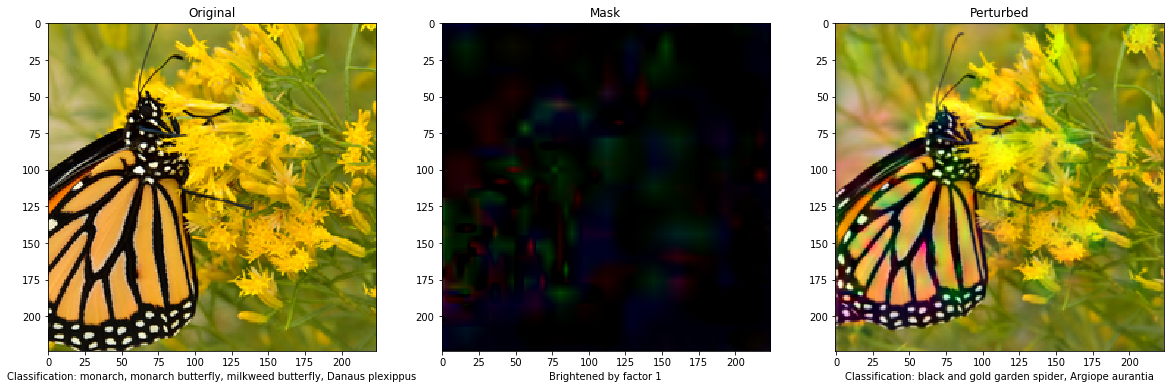

In [27]:
# Define Global variables
levels = 4 # Note 5 is limit due to the fact we crop all images to be 3 x 224 x224
K = 500
mask_image_enhance = 1
steps = 250
eps = 2 * 8 / 225
step_alpha = 3

# Define the path of the image to test the wavelet transform on, can swap other images to test on:
img_path = "test-images/butterfly.png"
# img_path = "test-images/car.png"
# img_path = "test-images/panda.png"
# img_path = "test-images/snail.png"
# img_path = "test-images/food.png"
# img_path = "test-images/shoes.png"

# Load the image as a pil, a pytorch tensor and another normalised pytorch tensor (see functions above)
img_pil_uncropped, img_tensor, img_tensor_norm = load_image(img_path)

# Get a PIL image for the image tensor that is cropped
original_img_pil = get_image_from_tensor(img_tensor)

# Try and create low energy perturbation that confuses the classifier
perturbed_img_pil, perturbed_img_tensor, mask_img_pil, mask_img_tensor, original_class, original_conf, perturbed_class, perturbed_conf, energy_ratio, exit_status = create_adversary_nontargeted(img_tensor_norm, levels, K, labels, step_alpha) 

# Plot the result
if exit_status == 1:
    plot_images_sbs(original_img_pil, mask_img_pil, perturbed_img_pil, original_class, perturbed_class, mask_image_enhance, figure_num=1)
